In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

DATA_PATH = '../data/merged.pickle'

In [9]:
import cPickle as pickle

with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

labels = np.load('../data/labels.npy')

In [10]:
non_zero_lumi_index = np.where(
    (data['_instantLumi_minibias'] != 0.0) | \
    (data['_instantLumi_muons'] != 0.0) | \
    (data['_instantLumi_photons'] != 0.0)
)[0]

In [11]:
not_features = [
    '_luminosityBlock',
    '_run',
    '_instantLumi_minibias',
    '_instantLumi_muons',
    '_instantLumi_photons'
]

features = sorted(set(data.columns) - set(not_features))

X = data[features].values
y = labels
weights = data['_instantLumi_minibias'].values

In [12]:
print 'Non-zero luminosity:', non_zero_lumi_index.shape[0], 'lumisections'

Non-zero luminosity: 26046 lumisections


In [13]:
from rep.estimators import XGBoostClassifier

from sklearn.metrics import roc_auc_score

from rep.utils import train_test_split

In [14]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X, y, weights, test_size=0.8)

In [15]:
depth = 6

In [16]:
%%time

xgb = XGBoostClassifier(n_estimators=128, max_depth=depth, eta=0.3, nthreads=32)
xgb.fit(X, y, sample_weight=weights)

CPU times: user 1h 5min 11s, sys: 13.5 s, total: 1h 5min 24s
Wall time: 2min 23s


In [17]:
%%time

xgb = XGBoostClassifier(n_estimators=32, max_depth=depth, eta=0.3, nthreads=32)
xgb.fit(X, y, sample_weight=weights)

CPU times: user 16min 44s, sys: 5.09 s, total: 16min 49s
Wall time: 44.3 s


In [18]:
%%time

xgb = XGBoostClassifier(n_estimators=32, max_depth=depth, eta=0.3, nthreads=32)
xgb.fit(X[:, :500], y, sample_weight=weights)

CPU times: user 4min 6s, sys: 1.49 s, total: 4min 7s
Wall time: 9.84 s


In [19]:
%%time

xgb = XGBoostClassifier(n_estimators=64, max_depth=depth, eta=0.3, nthreads=32)
xgb.fit(X[:, :500], y, sample_weight=weights)

CPU times: user 7min 29s, sys: 2.38 s, total: 7min 31s
Wall time: 16.9 s


In [20]:
xgb_aucs = list()

depths = [4, 5, 6, 7, 8, 9]

for depth in depths:
    print 'XGB for depth %d' % depth
    
    xgb = XGBoostClassifier(n_estimators=32, max_depth=depth, eta=0.3, nthreads=32)
    xgb.fit(X_train, y_train, sample_weight=w_train)

    aucs = np.array([
        roc_auc_score(y_val, s[:, 1], sample_weight=w_val)
        for s in xgb.staged_predict_proba(X_val, step=1)
    ])

    xgb_aucs.append(aucs)
    
    print 'Done'

XGB for depth 4
Done
XGB for depth 5
Done
XGB for depth 6
Done
XGB for depth 7
Done
XGB for depth 8
Done
XGB for depth 9
Done


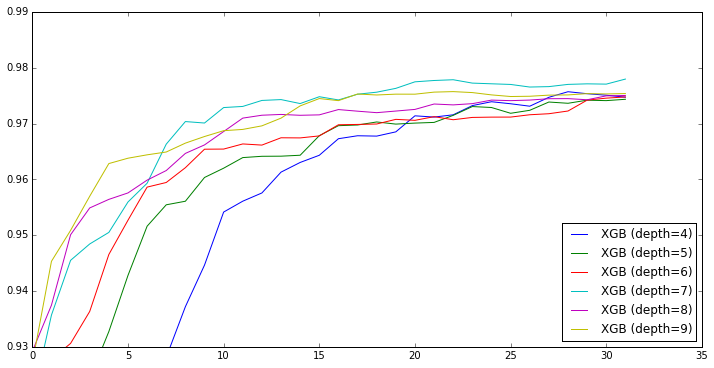

In [21]:
plt.figure(figsize=(12, 6))

for depth, aucs in zip(depths, xgb_aucs):
    plt.plot(aucs, label='XGB (depth=%d)' % depth)

plt.ylim([0.93, 0.99])
plt.legend(loc='lower right')
plt.show()

In [22]:
from sklearn.ensemble import ExtraTreesClassifier


ext_aucs = list()

depths = [5, 7, 9, 10, 11, 13, 15, 17, 19]
n = 512

for depth in depths:
    print 'Extra Trees for depth %d' % depth
    
    ext = ExtraTreesClassifier(n_estimators=n, max_depth=depth, n_jobs=-1)
    ext.fit(X_train, y_train, sample_weight=w_train)
    
    s = ext.predict_proba(X_val)
    aucs = roc_auc_score(y_val, s[:, 1], sample_weight=w_val)

    ext_aucs.append(aucs)
    
    print 'Done'

Extra Trees for depth 5
Done
Extra Trees for depth 7
Done
Extra Trees for depth 9
Done
Extra Trees for depth 10
Done
Extra Trees for depth 11
Done
Extra Trees for depth 13
Done
Extra Trees for depth 15
Done
Extra Trees for depth 17
Done
Extra Trees for depth 19
Done


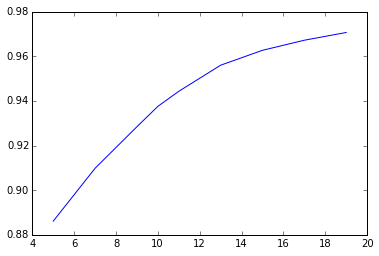

In [23]:
plt.plot(depths, ext_aucs)

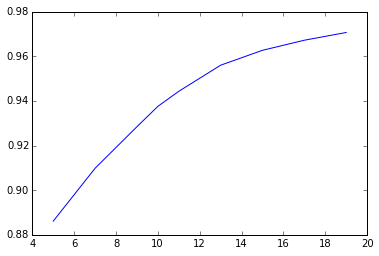

In [24]:
plt.plot(depths, ext_aucs)

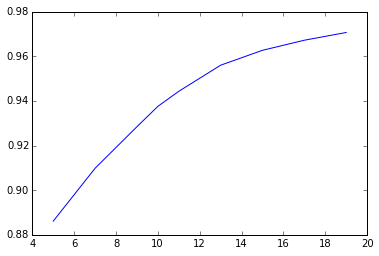

In [25]:
plt.plot(depths, ext_aucs)

In [27]:
def cross_val_score(clf, X, y, w, n_folds = 10, n_checks = 10):
    from sklearn.cross_validation import StratifiedKFold
    from itertools import islice

    proba = []
    labels = []
    weights = []
    kfold = StratifiedKFold(y, n_folds = n_folds, shuffle=True)
    
    for train_ind, test_ind in islice(kfold, n_checks):
        clf.fit(X[train_ind], y[train_ind], sample_weight=w[train_ind])
        
        proba.append(
            clf.predict_proba(X[test_ind])[:, 1]
        )
        labels.append(y[test_ind])
        weights.append(w[test_ind])
        
    proba = np.hstack(proba)
    labels = np.hstack(labels)
    weights = np.hstack(weights)
    
    return labels, proba, weights

def get_thresholds(y_test, p_test, w_test,
                   max_loss_rate = 0.0, max_pollution_rate = 0.0,
                   thr_quantile=0.95, plot = True, title = ''):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    
    fpr, tpr, thr_roc = roc_curve(y_test, p_test, sample_weight=w_test)
    auc_score = auc(fpr, tpr, reorder=True)
    
    precision, recall, thr = precision_recall_curve(y_test, p_test, sample_weight=w_test)
    pr_auc = auc(precision, recall, reorder = True)
    
    thr = np.hstack([thr, [1.0]])
    ### FNR * P + TNR * N
    ### FNR = 1 - TPR
    ### TNR = 1 - FPR
    
    cut_lumi = np.zeros(shape=thr.shape[0])
    
    for i, t in enumerate(thr):
        cut_lumi[i] = np.sum(w_test[p_test < t])
    
    cut_lumi = cut_lumi / np.sum(w_test)
    
    pollution = 1.0 - precision
    loss = 1.0 - recall
    
    if plot:
        fs, axs = plt.subplots(1, 4, figsize=(18, 4))
        plt.suptitle(title)

        axs[0].set_title('ROC curve')
        axs[0].plot([0, 1], [0, 1], '--')
        axs[0].plot(fpr, tpr, label = "AUC = %.4f" % auc_score)
        axs[0].set_xlabel('False Positive Rate')
        axs[0].set_ylabel('True Positive Rate')
        axs[0].legend(loc='lower right')

        axs[1].set_title('Pollution-Loss curve')
        axs[1].plot([1, 1], [0, 0], '--')
        axs[1].plot(pollution, loss)
        axs[1].set_xlabel('Pollution Rate')
        axs[1].set_ylabel('Loss Rate')
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

        axs[2].set_title('Pollution/Loss rates')
        axs[2].plot(thr, pollution, label='pollution rate')
        axs[2].plot(thr, loss, label='loss rate')
        axs[2].set_xlabel('threshold')
        axs[2].set_ylabel('rate')
        axs[2].legend(loc = 'upper left')
        axs[2].set_yscale('log')
        
        axs[3].set_title('Pollution/Loss rates')
        axs[3].plot(cut_lumi, pollution, label='pollution rate')
        axs[3].plot(cut_lumi, loss, label='loss rate')
        axs[3].set_xlabel('sum lumi below threshold')
        axs[3].set_ylabel('rate')
        axs[3].legend(loc = 'upper left')
        axs[3].set_yscale('log')
        axs[3].set_xlim([0, 1])

        plt.show()

    thr_high_acceptable = thr[pollution <= max_pollution_rate]
    thr_low_accaptable = thr[loss <= max_loss_rate]
        
    try:
        thr_high = np.percentile(thr_high_acceptable, q=(1.0 - thr_quantile) * 100.0)
    except:
        thr_high = 1.0

    try:
        thr_low = np.percentile(thr_low_accaptable, q=thr_quantile * 100.0)
    except:
        thr_low = 0.0
        
    return thr_low, thr_high

In [28]:
def build_predictions(clf, X, y, w, thr_q = 0.90,
                      n_folds = 10, n_checks=10, max_loss_rate = 0.0, max_pollution_rate = 0.0,
                      title = '', plot = True):
    y_test, p_test, w_test = cross_val_score(clf, X, y, w, n_folds, n_checks)
    
    thr_low, thr_high = get_thresholds(
        y_test, p_test, w_test,
        max_loss_rate = max_loss_rate, max_pollution_rate = max_pollution_rate,
        thr_quantile=thr_q, plot = plot, title = title
    )
        
    
    clf.fit(X, y, sample_weight=w)
    
    return clf, thr_low, thr_high

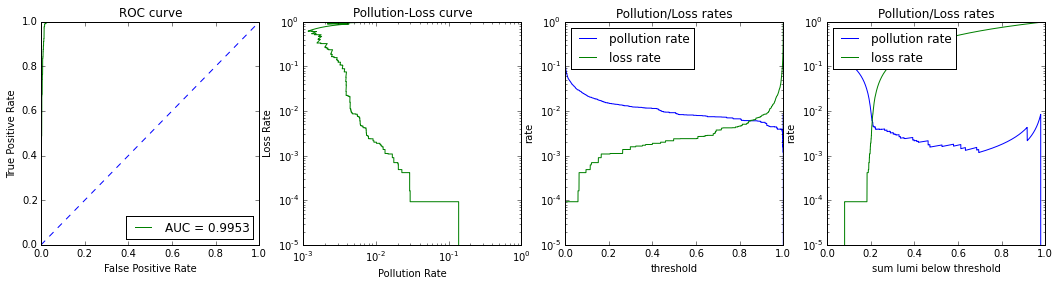

CPU times: user 3h 31min 12s, sys: 47.8 s, total: 3h 32min
Wall time: 8min 37s


In [29]:
%%time

from rep.estimators import XGBoostClassifier

clf = XGBoostClassifier(n_estimators=64, eta=0.3, nthreads=32, max_depth = 7, random_state=7777)

build_predictions(clf, X, y, weights, n_folds=10, n_checks=5)

In [30]:
def stream_learning(clf, X, y, w,
                    n_folds=10, skip_first_folds = None,
                    max_loss_rate=0.01, max_pollution_rate = 0.01,
                    cv_folds = 10, cv_checks = 5, thr_q = 0.9):
    if skip_first_folds is None:
        skip_first_folds = int(np.ceil(n_folds / 5.0))
    
    from sklearn.cross_validation import StratifiedKFold
    folds = StratifiedKFold(y, n_folds=n_folds, shuffle=True, random_state=7777).test_folds
    y_predicted = np.zeros(X.shape[0], dtype='int')
    
    threshold_low = np.zeros(n_folds)
    threshold_high = np.zeros(n_folds)
    
    X_train = np.zeros(shape = (0, X.shape[1]))
    y_train = np.zeros(shape = 0)
    w_train = np.zeros(shape = 0)
    
    rejection_rates = np.zeros(shape=n_folds)
    manual_work = np.zeros(shape=n_folds)

    loss_rates = np.zeros(shape=n_folds)
    pollution_rates = np.zeros(shape=n_folds)
    
    for iteration in xrange(n_folds):
        indx = np.where(folds == iteration)[0]

        if X_train.shape[0] == 0 or iteration < skip_first_folds:
            y_predicted[indx] == 0
            X_train = np.vstack([X_train, X[indx, :]])
            y_train = np.hstack([y_train, y[indx]])
            w_train = np.hstack([w_train, w[indx]])
            
            rejection_rates[iteration] = 1.0
            pollution_rates[iteration] = 0.0
            loss_rates[iteration] = 0.0
        else:
            clf, thr_low, thr_high = build_predictions(
                clf, X_train, y_train, w_train, n_folds=cv_folds, n_checks=cv_checks, thr_q = thr_q,
                max_loss_rate = max_loss_rate, max_pollution_rate = max_pollution_rate,
                title='Iteration %d' % iteration
            )

            proba = clf.predict_proba(X[indx, :])[:, 1]
            
            rejected_indx = indx[(proba > thr_low) & (proba < thr_high)]
            
            y_predicted[indx[proba > thr_high]] = 1
            y_predicted[indx[proba < thr_low]] = -1
            y_predicted[rejected_indx] = 0
            
            X_train = np.vstack([X_train, X[rejected_indx, :]])
            y_train = np.hstack([y_train, y[rejected_indx]])
            w_train = np.hstack([w_train, w[rejected_indx]])
            
            rejection_rates[iteration] = np.sum(w[rejected_indx]) / np.sum(w[indx])
            manual_work[iteration] = float(rejected_indx.shape[0]) / indx.shape[0]
            
            w_i = w[indx]

            ### Unrecognized good lumisections to all good lumisections
            fn_indx = (y_predicted[indx] == -1) & (y[indx] == 1)

            if np.sum(fn_indx) == 0 or np.sum(y[indx] == 1) == 0:
                loss_rates[iteration] = 0.0
            else:
                loss_rates[iteration] = np.sum(w_i[fn_indx]) / np.sum(w_i[y[indx] == 1])
                # loss_rates[iteration] = float(FN) / np.sum(y[indx] == 1)


            ### Bad lumisections predicted as good
            fp_indx = (y_predicted[indx] == 1) & (y[indx] == 0)

            if np.sum(fp_indx) == 0 or np.sum(y_predicted[indx] == 1) == 0:
                pollution_rates[iteration] = 0.0 
            else:
                pollution_rates[iteration] = np.sum(w_i[fp_indx]) / np.sum(w_i[y_predicted[indx] == 1])
                # pollution_rates[iteration] = float(FP) / np.sum(y_predicted[indx] == 1)

    return rejection_rates, manual_work, loss_rates, pollution_rates

In [ ]:
font = {
    'family' : 'normal',
    'weight' : 'normal',
    'size'   : 10
}

import matplotlib
matplotlib.rc('font', **font)

In [ ]:
import itertools

folds = 10
skip_folds = 3
thr_q = 0.97

cv=7
checks=4

clf = XGBoostClassifier(n_estimators=32, eta=0.3, nthreads=32, max_depth = 6, random_state=7777)

max_lrs = np.linspace(0.0, 0.01, num=11)
max_prs = np.linspace(0.0, 0.01, num=11)

rrs = np.ones((max_lrs.shape[0], max_prs.shape[0], folds))
mws = np.ones((max_lrs.shape[0], max_prs.shape[0], folds))
prs = np.ones((max_lrs.shape[0], max_prs.shape[0], folds))
lrs = np.ones((max_lrs.shape[0], max_prs.shape[0], folds))

for lr_i, lr in enumerate(max_lrs):
    for pr_i, pr in enumerate(max_prs):
        print 'Loss Rate constraint: %.2e' % lr
        print 'Pollution Rate constraint: %.2e' % pr

        rrs[lr_i, pr_i, :], mws[lr_i, pr_i, :], lrs[lr_i, pr_i, :], prs[lr_i, pr_i, :] = stream_learning(
            clf, X, y, weights, n_folds=folds, 
            cv_folds=cv, cv_checks=checks,
            skip_first_folds=skip_folds,
           max_loss_rate = lr, max_pollution_rate = pr, thr_q = thr_q
        )

        plt.figure(figsize=(8,8))
        plt.title('Stream learning')
        plt.plot(rrs[lr_i, pr_i, :], label='rejection rate')
        plt.plot(lrs[lr_i, pr_i, :], label='loss rate')
        plt.plot(prs[lr_i, pr_i, :], label='pollution rate')
        plt.xlabel('iteration')
        plt.legend()
        plt.show()

        print 'Avg. rejection rate: %.3e' % np.mean(rrs[lr_i, pr_i, :])
        print 'Avg. loss rate: %.3e' % np.mean(lrs[lr_i, pr_i, :])
        print 'Avg. pollution rate: %.3e' % np.mean(prs[lr_i, pr_i, :])
        print '-' * 25

In [ ]:
font = {
    'family' : 'normal',
    'weight' : 'normal',
    'size'   : 16
}

import matplotlib
matplotlib.rc('font', **font)

In [57]:
aprs = np.mean(prs, axis=2)
alrs = np.mean(lrs, axis=2)

<matplotlib.colorbar.Colorbar instance at 0x7f955d300c20>

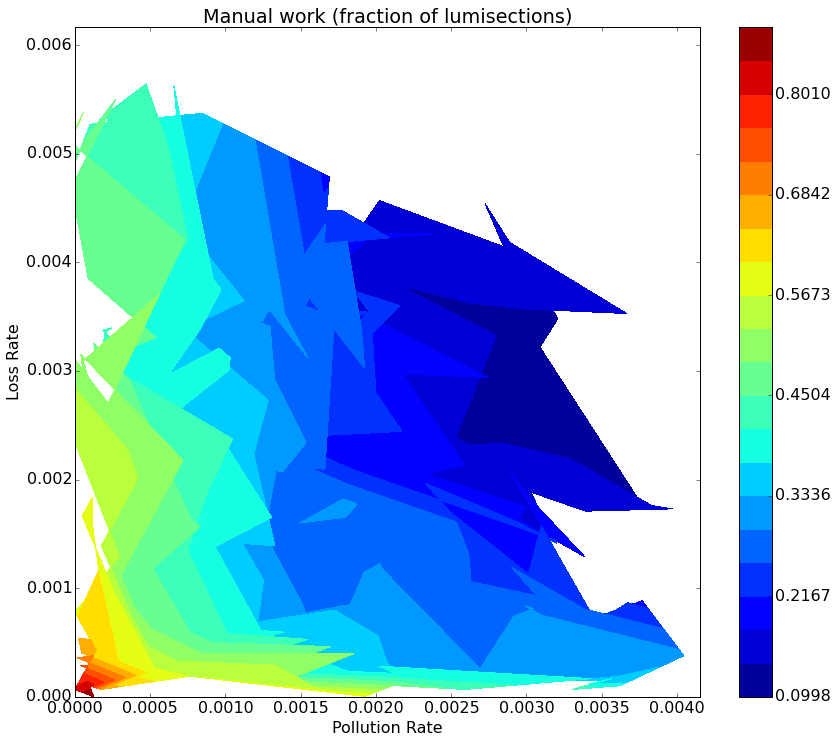

In [76]:
plt.figure(figsize=(14, 12))
plt.title('Manual work (fraction of lumisections)')
amws =  np.mean(mws[:, :, -5:], axis=2)

plt.contourf(
    aprs, alrs, amws,
    levels=np.linspace(np.min(amws), np.max(amws), num=21),
    #cmap=plt.cm.Reds
)

plt.ylabel('Loss Rate')
plt.xlabel('Pollution Rate')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f955d134368>

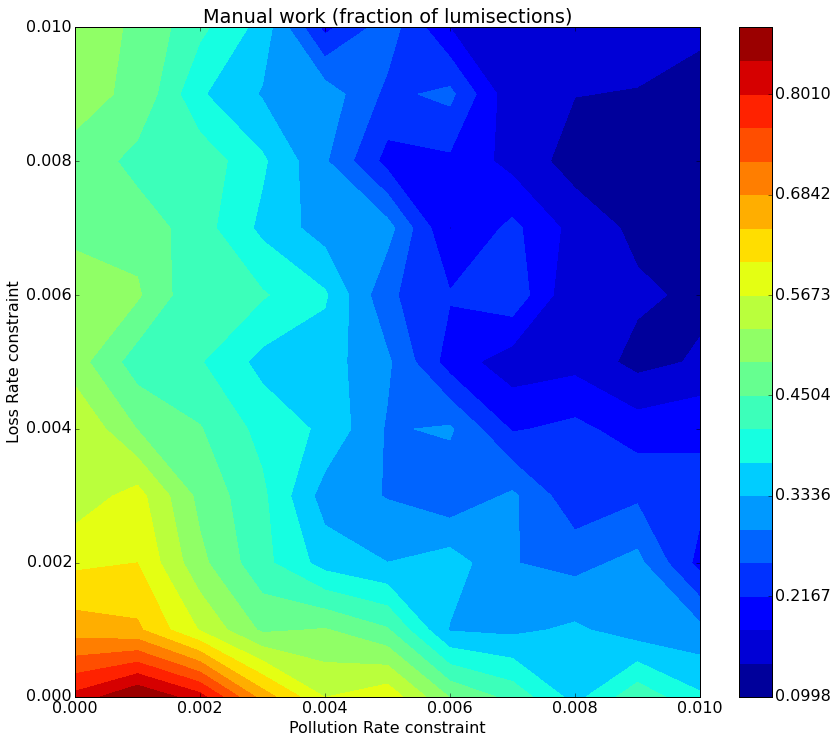

In [77]:
plt.figure(figsize=(14, 12))
plt.title('Manual work (fraction of lumisections)')
amws =  np.mean(mws[:, :, -5:], axis=2)

plt.contourf(
    max_prs, max_lrs, amws,
    levels=np.linspace(np.min(amws), np.max(amws), num=21),
    #cmap=plt.cm.Reds
)

plt.ylabel('Loss Rate constraint')
plt.xlabel('Pollution Rate constraint')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f955cfc6b48>

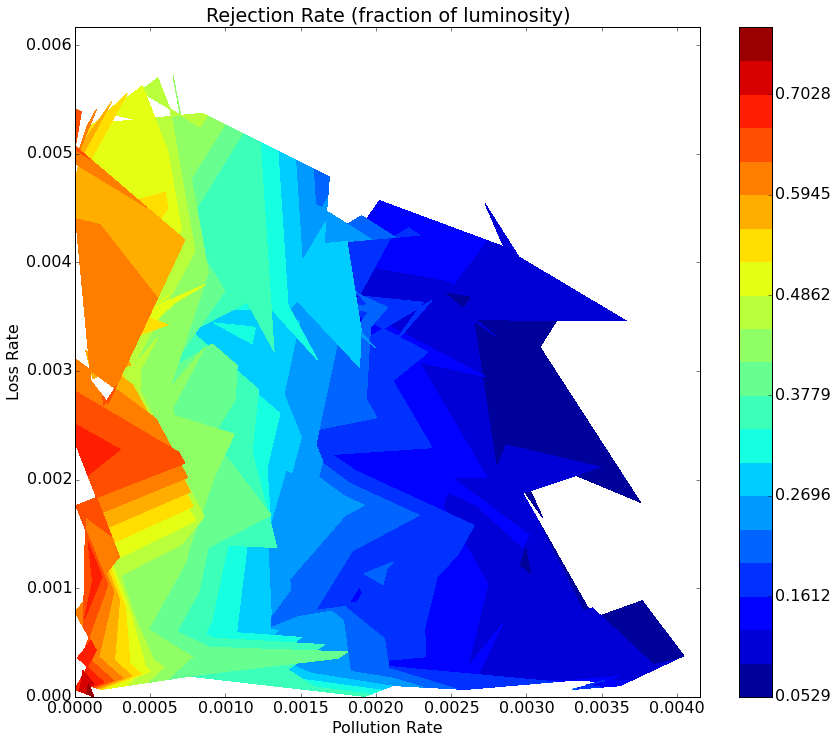

In [78]:
plt.figure(figsize=(14, 12))
plt.title('Rejection Rate (fraction of luminosity)')
arrs =  np.mean(rrs[:, :, -5:], axis=2)

plt.contourf(
    aprs, alrs, arrs,
    levels=np.linspace(np.min(arrs), np.max(arrs), num=21),
    #cmap=plt.cm.Reds
)

plt.ylabel('Loss Rate')
plt.xlabel('Pollution Rate')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f955ce3eea8>

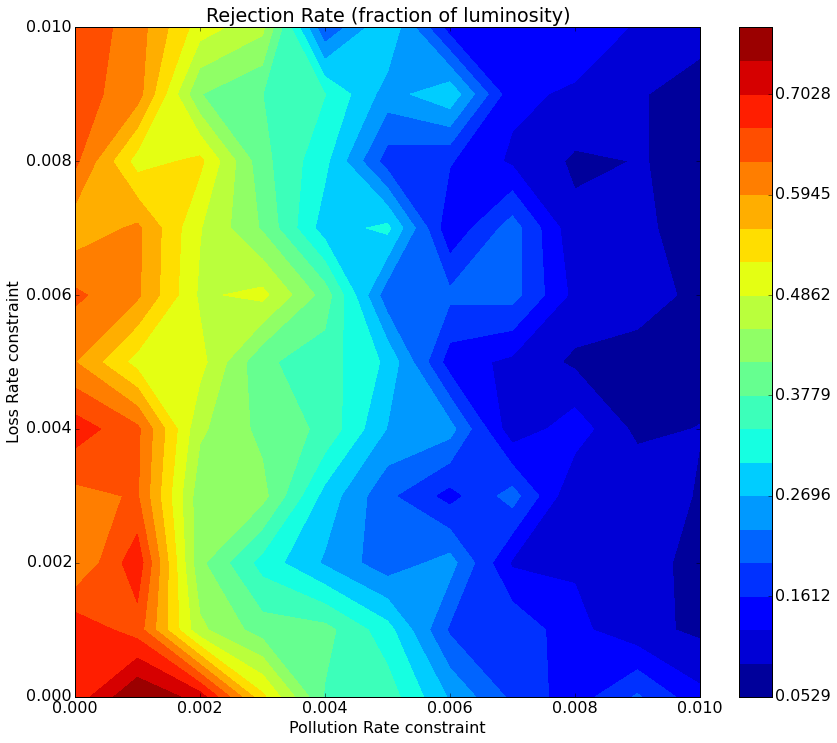

In [79]:
plt.figure(figsize=(14, 12))
plt.title('Rejection Rate (fraction of luminosity)')
arrs =  np.mean(rrs[:, :, -5:], axis=2)

plt.contourf(
    max_prs, max_lrs, arrs,
    levels=np.linspace(np.min(arrs), np.max(arrs), num=21),
    #cmap=plt.cm.Reds
)

plt.ylabel('Loss Rate constraint')
plt.xlabel('Pollution Rate constraint')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f955ccdf950>

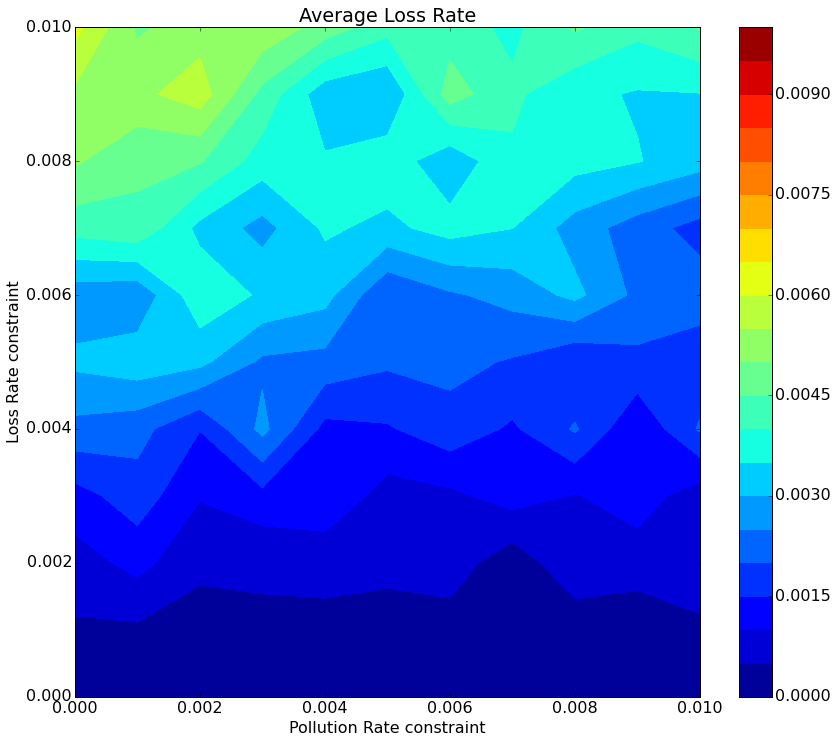

In [80]:
plt.figure(figsize=(14, 12))
plt.title('Average Loss Rate')
alrs =  np.mean(lrs, axis=2)

plt.contourf(
    max_prs, max_lrs, alrs,
    levels=np.linspace(0, 0.01, num=21),
    #cmap=plt.cm.Reds
)

plt.ylabel('Loss Rate constraint')
plt.xlabel('Pollution Rate constraint')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f955cb5e638>

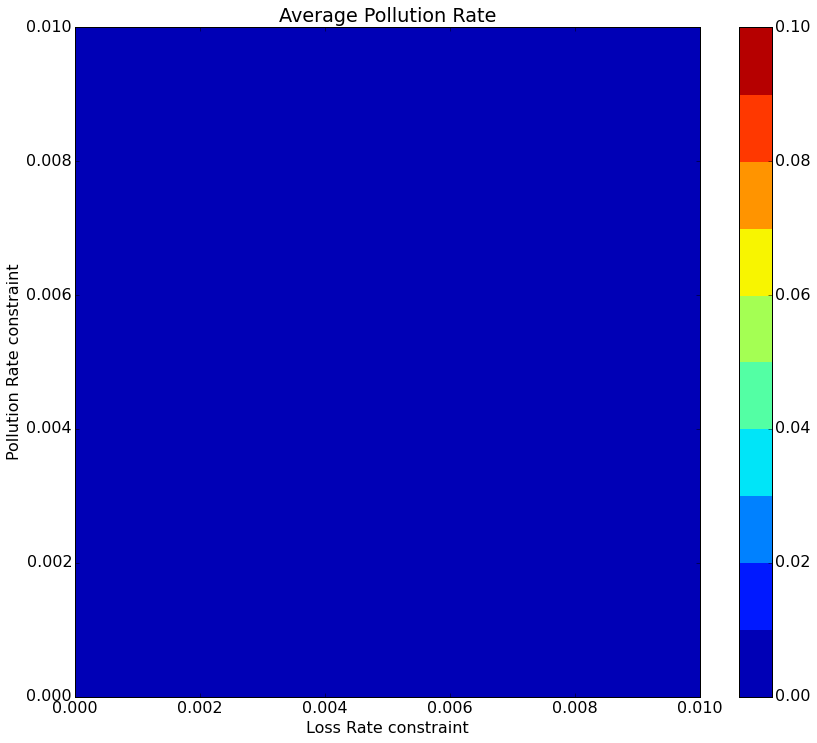

In [81]:
plt.figure(figsize=(14, 12))
plt.title('Average Pollution Rate')
aprs =  np.mean(prs, axis=2)

plt.contourf(
    max_prs, max_lrs, aprs.T,
    levels=np.linspace(0, 0.1, num=11),
    #cmap=plt.cm.Reds
)

plt.xlabel('Loss Rate constraint')
plt.ylabel('Pollution Rate constraint')
plt.colorbar()